<a href="https://colab.research.google.com/github/yuvalofek/Deep_Learning/blob/master/DeepLearningAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ECE472, Deep Learning – Assignment 2**

Submit by Sept. 16, 10pm

tldr: Perform binary classification on the spirals
dataset using a multi-layer perceptron.
You must generate the data yourself.

* I used the convention x in R^2 is the input vectors and y 
in {0,1} are labels


In [37]:
import numpy as np
import tensorflow as tf
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib

In [56]:
BATCH_SIZE = 64
#data parameters
N = 250
noise_sd = 0.3
offset = 2
seed = 4
theta_range1 = (np.pi/2, 4*np.pi)
theta_range2 = (3*np.pi/2, 5*np.pi)

#model parameters:
num_steps = 2_500
layer_sizes = [2,32, 16, 8, 8, 1]
lambd = 0.01
colors = ['red','blue']

#Plotting Parameters:
N_bounds = 200

class spiral_data:
  def __init__(self, theta_range1, theta_range2,
               noise_sd, offset, N1, shuffle = True,
               N2 = None):
    def spiral(theta_range, noise_sd, offset, N):
      '''
      Generate N uniformally sampled points in a spiral with theta range 
      theta_range with normal noise of variance noise_sd, and r offset from
      zero of offset. 
      '''
      range_min, range_mx = theta_range
      theta = npr.uniform(range_min, range_mx,size = (N,1))
      r = offset + theta - range_min +npr.normal(size = (N,1))*noise_sd
      x_cord, y_cord = r*np.sin(theta), r*np.cos(theta)
      return np.concatenate((x_cord,y_cord), axis =1) 

    #create 2 spirals given input parameters
    if N2 is None:
      N2 = N1
    spiral1 = spiral(theta_range1, noise_sd, offset, N1)
    spiral2 = spiral(theta_range2, noise_sd, offset, N2)

    self.x = np.concatenate((spiral1, spiral2), axis = 0)
    self.y = np.concatenate((np.ones(shape = (N1,1)),
                             np.zeros(shape = (N2,1))), axis = 0)
    if shuffle:
      shuffler =  np.random.permutation(len(self.x))
      self.x = self.x[shuffler]
      self.y = self.y[shuffler]

  def get_batch(self, batch_size = BATCH_SIZE):
    '''
    return a batch of random batch_size features and their labels
    '''
    idxs = range(len(self.x))
    choices = npr.choice(idxs, batch_size)
    return (tf.convert_to_tensor(self.x[choices], dtype=tf.float32),
              tf.convert_to_tensor(self.y[choices], dtype=tf.float32))

class perceptron:
  def __init__(self,
               layer_sizes,
               lambd,
               seed,
               initializer = tf.keras.initializers.GlorotNormal):
    '''
    initialize weights and model parameters
    '''
    #store parameters
    self.layers = len(layer_sizes)
    self.lambd = lambd

    #initialize weights
    initializer = initializer(seed)
    params = {}
    for i in range(1, self.layers):
      params['W'+str(i)] = tf.Variable(initializer(shape=(layer_sizes[i-1],
                                                         layer_sizes[i])))
      params['b'+str(i)] = tf.Variable(initializer(shape=(1,
                                                         layer_sizes[i])))
    self.params = params

  def layer_pass(self, x, W,b, activation):
    '''
    A pass through one layer with weights W and offset b, followed by 
    an activation function
    '''
    Z = tf.matmul(x,W)+b
    if activation == "relu":
      A = tf.nn.relu(Z)
    elif activation == 'sigmoid':
      A = tf.nn.sigmoid(Z)
    else:
      A = Z
    return A

  def predict(self, x):
    '''
    predict y given input x and current model weights
    '''
    A = x
    params = self.params
    activation = 'relu'
    for i in range(1, self.layers):
      A_prev = A
      if i+1 == self.layers:
        activation = 'sigmoid'
      A = self.layer_pass(A_prev, params['W'+str(i)],
                     params['b'+str(i)], activation)
    return A

  def loss(self, y_hat, y):
    '''
    binary cross entropy loss with L2 normalization
    '''
    loss = tf.reduce_mean(-y*tf.math.log(y_hat)-(1-y)*tf.math.log(1-y_hat))
    #L2 regularization
    for i in range(1,self.layers):
      loss += tf.nn.l2_loss(self.params['W'+str(i)])*self.lambd
    return loss

  def step(self,optimizer, cache):
    '''
    A single step - predicting values, getting loss,
    & using the gradients of loss to update the 
    parameters with Adam optimizer
    '''
    with tf.GradientTape(persistent=True) as tape: 
      x,y = d1.get_batch()
      tape.watch(self.params)
      y_hat = self.predict(x)
      lss = self.loss(y_hat,y)
    cache.append(lss)

    #get update paramaters
    grads = tape.gradient(lss, self.params)
    optimizer.apply_gradients(zip(grads.values(), self.params.values()))
    #return updated loss cache
    return cache

#run experiment 
#generate data
npr.seed(seed)
d1 = spiral_data(theta_range1, theta_range2, noise_sd, offset, N)

#initialize perceptron
p = perceptron(layer_sizes,lambd,seed)

cache = []
optimizer = tf.optimizers.Adam()
for i in range(num_steps):
  cache = p.step(optimizer, cache)
  #Training printout
  if not((i+1)%100):
    p_train = int((i+1)/num_steps*100)
    y_hat = p.predict(tf.convert_to_tensor(d1.x, dtype=tf.float32))
    err =  sum(abs(np.round(y_hat)-d1.y))[0]/len(d1.y)
    curr_loss = cache[-1].numpy()
    print(f'\r Training completed: {p_train}% |',
          f'Loss: {curr_loss} |',
          f'Test error: {err}',
          end = '')

 Training completed: 100% | Loss: 0.2114318311214447 | Test error: 0.0

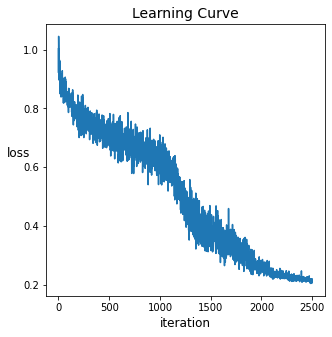

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


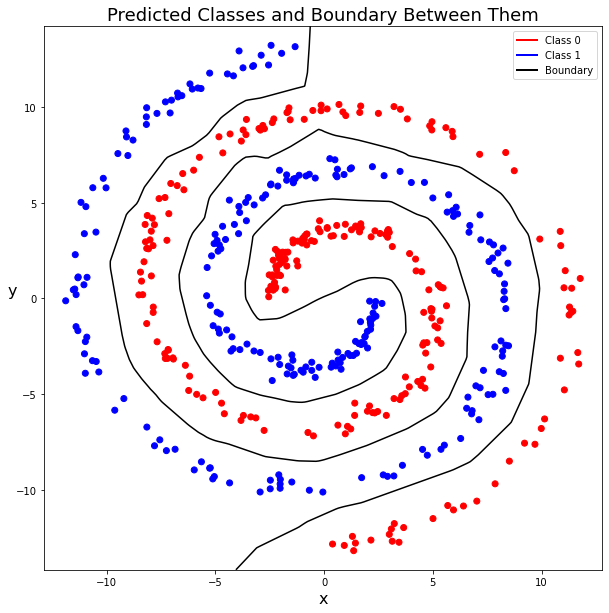

In [58]:
#learning curve
plt.figure
plt.figure(figsize=(5,5))
plt.plot([lss.numpy() for lss in cache])
plt.title('Learning Curve', fontsize=14)
plt.xlabel('iteration', fontsize=12)
h = plt.ylabel('loss', fontsize=12)
h.set_rotation(0)
plt.show()

#final prediction plot
y_hat = p.predict(tf.convert_to_tensor(d1.x, dtype=tf.float32))

#boundary line
x_coord, y_coord = np.meshgrid(
        np.linspace(np.min(d1.x[:, 0])-1, np.max(d1.x[:, 0])+1, N_bounds),
        np.linspace(np.min(d1.x[:, 1])-1, np.max(d1.x[:, 1])+1, N_bounds),
        )
z = np.vstack((x_coord.flatten(), y_coord.flatten())).T
z_out = p.predict( tf.convert_to_tensor(z, dtype=tf.float32)).numpy()

#plotting
plt.figure
plt.figure(figsize=(10,10))
plt.scatter(d1.x[:,0], d1.x[:,1], c=np.round(y_hat.numpy(),0),
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('x', fontsize=16)
h = plt.ylabel('y', fontsize=16)
h.set_rotation(0)
plt.title('Predicted Classes and Boundary Between Them', fontsize=18)
plt.contour(x_coord, y_coord,
            np.squeeze(np.reshape(z_out, x_coord.shape)),
            levels=1, colors="k", )
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='k', lw=2)]

plt.legend(custom_lines, ['Class 0', 'Class 1', 'Boundary'])
plt.savefig('Prediction.eps', format='eps')

plt.show()